In [14]:
import json
import nltk
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.distributions.normal as normal
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt

from torch.nn.utils import clip_grad_norm_
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
from nltk.tokenize import word_tokenize
from nltk.tokenize import MWETokenizer

from gensim.models import Word2Vec

In [15]:
torch.manual_seed(1)

In [16]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to C:\Users\Mihaela
[nltk_data]     Stoycheva\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

### Load data

In [9]:
def load_data(filename, max_sentence_len):
    # the tokenizer splits <unk> so we use MWETokenizer to re-merge it
    data_original = []
    data_padded = []
    with open(filename) as f:
        for line in f:
            sentence, padded_sentence = tokenize_sentence(line, max_sentence_len)
            data_original.append(sentence)
            data_padded.append(padded_sentence)
    
    return data_original, data_padded

def tokenize_sentence(string, max_sentence_len):
    merger = MWETokenizer([('<', 'unk', '>')], separator = '') 
    sentence = word_tokenize(string.strip())       # tokenize sentence
    sentence = merger.tokenize(sentence)         # merge <unk>
    sentence = sentence[:max_sentence_len - 2]   # cut sentence at max_sentence_length
    sentence = ['<sos>'] + sentence + ['<eos>']  # add start and end-of-sentence tags

    # pad the rest of the sentence
    padded_sentence = sentence.copy()
    padded_sentence.extend(['<pad>']*(max_sentence_len - len(sentence))) 
    
    return sentence, padded_sentence

In [10]:
max_sentence_length = 50
train_data, train_data_padded = load_data("data/ptb.train.txt", max_sentence_length)
val_data, val_data_padded = load_data("data/ptb.valid.txt", max_sentence_length)
test_data, test_data_padded = load_data("data/ptb.test.txt", max_sentence_length)

### Create Word2Vec word embeddings

In [6]:
embedding_size = 500
num_epochs_to_train = 10

In [7]:
word2vec_model = Word2Vec(train_data, min_count=1, size=embedding_size, window=5)
word2vec_model.train(train_data, epochs=num_epochs_to_train, total_examples=word2vec_model.corpus_count)

(6666616, 9696000)

In [8]:
word2vec_model.wv.most_similar("stocks")
# word2vec_model.wv['credit']

[('issues', 0.7121069431304932),
 ('stock-index', 0.691788911819458),
 ('traders', 0.6770775318145752),
 ('index', 0.6716479063034058),
 ('nasdaq', 0.6556688547134399),
 ('investors', 0.6482288837432861),
 ('trades', 0.6452388763427734),
 ('futures', 0.6339257955551147),
 ('selling', 0.6047229170799255),
 ('stock-market', 0.6016063690185547)]

In [9]:
vocabulary_size = len(word2vec_model.wv.vocab)
print("size of the vocabulary:", vocabulary_size)

size of the vocabulary: 10005


### Split data into batches

In [10]:
def get_batches(data, data_padded, batch_size, pad_index, word2vec_model):
    inputs = []
    targets = []
    lengths = []
    for i in range(len(data) // batch_size):
        # take batch_size sentences from the data each time
        batch_sentences = data[i*batch_size:(i+1)*batch_size]
        batch_sentence_lens = [len(x) for x in batch_sentences]
        
        # sentences in a batch have to be sorted in decreasing order of length (for pack_padded_sentence)
        sorted_pairs = sorted(zip(batch_sentence_lens,batch_sentences), reverse=True)
        batch_sentences = [sentence for length, sentence in sorted_pairs]
        batch_sentence_lens = [length-1 for length, sentence in sorted_pairs]
        
        # each input and target is a (batch_size x max_sentence_len-1 x 1) matrix
        # initially filled with the index for padditng tag <pad>
        input_batch = np.ones((batch_size, len(data_padded[0])-1, 1)) * pad_index
        target_batch = np.ones((batch_size, len(data_padded[0])-1, 1)) * pad_index
        
        # for each sentence in the batch, fill the corresponding row in current_batch
        # with the indexed of the words in the sentence (except for <pad>)
        for j, sentence in enumerate(batch_sentences):
            word_indexes = np.array([word2vec_model.wv.vocab[word].index for word in sentence])
            input_batch[j,0:len(sentence)-1,0] = word_indexes[:-1]
            target_batch[j,0:len(sentence)-1,0] = word_indexes[1:]
        
        # make the matrices into torch tensors and append
#         inputs.append(torch.tensor(input_batch))
#         targets.append(torch.tensor(target_batch))
        inputs.append(input_batch)
        targets.append(target_batch)
        lengths.append(batch_sentence_lens)
    return inputs, targets, lengths

### Define RNNLM

In [11]:
class RNNLM(nn.Module):
    def __init__(self, vocabulary_size, embedding_size, hidden_size, num_layers, embedding_weights):
        super(RNNLM, self).__init__()
        self.embed = nn.Embedding.from_pretrained(embedding_weights)
        self.lstm = nn.LSTM(embedding_size, hidden_size, num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_size, vocabulary_size)
        self.embedding_size = embedding_size
        
    def forward(self, x, hidden, x_lens, train=True):
        batch_size, max_len, _ = x.shape
        embedding_dim = self.embedding_size

        x = self.embed(torch.tensor(x, dtype=torch.long)).view(batch_size, max_len, embedding_dim)
        if train:
            x_lens = torch.tensor(x_lens, dtype=torch.long)
            x = pack_padded_sequence(x, x_lens, batch_first=True)

        out, hidden = self.lstm(x.float(), hidden) 
        
        if train:
            out, output_lens = pad_packed_sequence(out, batch_first=True, total_length=max_sentence_length-1)

        out = out.reshape(out.size(0)*out.size(1), out.size(2))
        out = self.linear(out)
        
        return out, hidden

### Train RNNLM

In [5]:
input_size = 100
output_size = 100
hidden_size = 50

In [5]:
batch_size = 20
use_first_k = 500
padding_index = vocabulary_size
train_batches, train_targets, train_sentence_lens = get_batches(train_data[:use_first_k], train_data_padded[:use_first_k], 
                                                                batch_size, padding_index, word2vec_model)

NameError: name 'vocabulary_size' is not defined

In [6]:
# make the word embeddings into a pythorch tensor
embedding_weights = word2vec_model.wv.vectors
embedding_weights = np.vstack((embedding_weights, np.zeros((1,embedding_size))))  # add zero vector for <pad>
embedding_weights = torch.tensor(embedding_weights)

NameError: name 'word2vec_model' is not defined

In [6]:
learning_rate = 0.001
num_layers = 1
epochs = 10

In [76]:
model = RNNLM(vocabulary_size, embedding_size, hidden_size, num_layers, embedding_weights)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [96]:
for epoch in range(epochs):
    hidden = (torch.zeros(num_layers, batch_size, hidden_size), torch.zeros(num_layers, batch_size, hidden_size))
    for i in range(len(train_batches)):
        x = train_batches[i]
        x_lens = train_sentence_lens[i]
        y = torch.tensor(train_targets[i].reshape(-1), dtype=torch.long)   
        h, c = hidden
        h = h.detach()
        c = c.detach()
        hidden = (h, c)
    
        outputs, hidden = model(x, hidden, x_lens)
        
        mask = (y < padding_index)
        loss = nn.CrossEntropyLoss()(outputs[mask], y[mask])

        model.zero_grad()
        loss.backward()
        clip_grad_norm_(model.parameters(), 0.5)
        optimizer.step()

    if epoch % 1 == 0:
        print ('Epoch [{}/{}], Loss: {:.4f}, Perplexity: {:5.2f}'
               .format(epoch + 1, epochs, loss.item(), np.exp(loss.item())))

Epoch [1/10], Loss: 8.8069, Perplexity: 6680.21
Epoch [2/10], Loss: 7.1356, Perplexity: 1255.87


KeyboardInterrupt: 

In [97]:
# Predict
test_sentences = ["he could see"]
sentence, _ = tokenize_sentence(test_sentences[0], max_sentence_length)
sentence = sentence[:-1]
word_indexes = np.array([word2vec_model.wv.vocab[word].index for word in sentence]).reshape(1, len(sentence), 1)
print(word_indexes.shape)

hidden = (torch.zeros(1, 1, hidden_size), torch.zeros(1, 1, hidden_size))
h, c = hidden
h = h.detach()
c = c.detach()
hidden = (h, c)

outputs, hidden = model(word_indexes, hidden, x_lens, train=False)
softmax_outputs = F.softmax(outputs, dim=1).detach().numpy()
last_word = softmax_outputs[-1,:]
predicted_next_word_idx = np.random.choice(range(len(last_word)), p=last_word)
print("Argmax: ", word2vec_model.wv.index2word[np.argmax(last_word)])
print("Next word: ", word2vec_model.wv.index2word[predicted_next_word_idx])

(1, 4, 1)
Argmax:  the
Next word:  toseland


In [17]:
class Encoder(nn.Module):
    def __init__(self, hidden_size, num_layers, embedding_weights, synthetic=False):
        super(Encoder, self).__init__()
        # parameters
        self.embedding_size = embedding_weights.shape[1]
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.batch_first = True
        
        #layers
        self.embed = nn.Embedding.from_pretrained(embedding_weights)
        self.lstm = nn.LSTM(self.embedding_size, self.hidden_size, self.num_layers, batch_first=self.batch_first)
        if synthetic:          
            for param in self.parameters():
                nn.init.uniform_(param, -0.01, 0.01)
        nn.init.uniform_(self.embed.weight, -0.1, 0.1)
        
    def forward(self, x, hidden, x_lens=None, train=True):
        batch_size, max_len, _ = x.shape
        
        x = torch.tensor(x, dtype=torch.long)  # make the input into a torch tensor
        x = self.embed(x).view(batch_size, max_len, self.embedding_size)

        if x_lens is not None and train:
            x_lens = torch.tensor(x_lens, dtype=torch.long)
            x = pack_padded_sequence(x, x_lens, batch_first=self.batch_first)
            
        output, hidden = self.lstm(x.float(), hidden) 

        if x_lens is not None and train:
            output, output_lens = pad_packed_sequence(output, batch_first=self.batch_first, 
                                                      total_length=max_sentence_length-1)
        
#         output = output.reshape(output.size(0)*output.size(1), output.size(2))
#         output = self.linear(output)
        
        return output, hidden
    
    def init_hidden(self, batch_size):
        h = torch.zeros(self.num_layers, batch_size, self.hidden_size)
        c = torch.zeros(self.num_layers, batch_size, self.hidden_size)
        return (h, c)

In [18]:
class Decoder(nn.Module):
    def __init__(self,hidden_size, num_layers, embedding_weights, synthetic=False):
        super(Decoder, self).__init__()
        # parameters
        self.vocabulary_size = embedding_weights.shape[0]
        self.embedding_size = embedding_weights.shape[1]
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.batch_first = True
        
        # layers
        self.embed = nn.Embedding.from_pretrained(embedding_weights)
        self.lstm = nn.LSTM(self.embedding_size, self.hidden_size, self.num_layers, batch_first=self.batch_first)
        self.linear = nn.Linear(self.hidden_size, self.vocabulary_size)
        if synthetic:          
            for param in self.parameters():
                nn.init.uniform_(param, -0.01, 0.01)
        nn.init.uniform_(self.embed.weight, -0.1, 0.1)

    def forward(self, x, hidden, x_lens=None, train=True):
        batch_size, max_len, _ = x.shape
        
        x = torch.tensor(x, dtype=torch.long)  # make the input into a torch tensor
        x = self.embed(x).view(batch_size, max_len, self.embedding_size)
        
        if x_lens is not None and train:
            x_lens = torch.tensor(x_lens, dtype=torch.long)
            x = pack_padded_sequence(x, x_lens, batch_first=self.batch_first)

        output, hidden = self.lstm(x.float(), hidden) 
        
        if x_lens is not None and train:
            output, output_lens = pad_packed_sequence(output, batch_first=self.batch_first, 
                                                      total_length=max_sentence_length-1)
        
        output = output.reshape(output.size(0)*output.size(1), output.size(2))
        output = self.linear(output)
        
        return output, hidden

In [19]:
class VAE(nn.Module):
    def __init__(self, hidden_dim, num_layers, embedding_weights, latent_dim, synthetic=False):
        super(VAE, self).__init__()
        self.encoder = Encoder(hidden_size, num_layers, embedding_weights, synthetic)
        self.decoder = Decoder(hidden_size, num_layers, embedding_weights, synthetic)
        self.latent_dim = latent_dim
        self.hidden_dim = hidden_dim
        self.batch_first = True
        
        self.hidden_to_mean = nn.Linear(2 * self.hidden_dim * num_layers, self.latent_dim, self.batch_first)
        self.hidden_to_logvar = nn.Linear(2 * self.hidden_dim * num_layers, self.latent_dim, self.batch_first)
        self.latent_to_hidden = nn.Linear(latent_dim, 2 * self.hidden_dim * num_layers, self.batch_first)
        if synthetic:          
            for param in self.parameters():
                nn.init.uniform_(param, -0.01, 0.01)
        
    def reparametrize(self, mean, log_variance):
        eps = torch.randn_like(mean)
        return mean + eps * torch.exp(0.5 * log_variance)
        
    def encode(self, x, x_lens=None):
        batch_size, max_len, _ = x.shape
        hidden = self.encoder.init_hidden(batch_size)
        _, hidden = self.encoder.forward(x, hidden, x_lens)
        return hidden
        
    def decode(self, hidden, x, x_lens=None, train=True):
        outputs, _ = self.decoder.forward(x, hidden, x_lens, train)
        return outputs
    
    def forward(self, x, x_lens=None):
        hidden = self.encode(x, x_lens)
        hidden_concatenated = torch.cat((hidden[0], hidden[1]), 2)
        
        mean = self.hidden_to_mean(hidden_concatenated)
        
        log_variance = self.hidden_to_logvar(hidden_concatenated)
        z = self.reparametrize(mean, log_variance)
        hidden = self.latent_to_hidden(z)
        
        hidden = torch.split(hidden, self.hidden_dim, dim=2)
        outputs = self.decode(hidden, x, x_lens)
        return mean, log_variance, outputs

In [30]:
def loss_function(outputs, labels, mean, log_variance, annealing=False, annealing_args=None):
    BCE = nn.CrossEntropyLoss(reduction='sum')(outputs, labels)
    KLD = -0.5 * torch.sum(1 + log_variance - mean.pow(2) - log_variance.exp()) 
    if annealing:
        kl_weight = kl_annealing_weight(annealing_args['type'], annealing_args['step'], annealing_args['k'], annealing_args['first_step'])
        KLD *= kl_weight
    loss = BCE + KLD
    loss /= mean.shape[1]
    return loss, BCE, KLD, kl_weight

def kl_annealing_weight(annealing_type, step, k, first_step):
    if annealing_type == 'logistic':
        return float(1/(1+np.exp(-k*(step-first_step))))
    elif annealing_type == 'linear':
        return min(1, step/first_step)
                           

In [ ]:
vae = VAE(hidden_size, num_layers, embedding_weights, 10)
vae_optimizer = torch.optim.Adam(vae.parameters(), lr=learning_rate)

In [88]:
for epoch in range(epochs):
    for i in range(len(train_batches)):
        x = train_batches[i]
        x_lens = train_sentence_lens[i]
        y = torch.tensor(train_targets[i].reshape(-1), dtype=torch.long)
    
        mean, log_variance, outputs = vae(x, x_lens)
        
        mask = (y < padding_index)
        #loss = nn.CrossEntropyLoss()(outputs[mask], y[mask]) # TODO CHANGE THIS TO VAE LOSS
        loss = loss_function(outputs[mask], y[mask], mean, log_variance)

        vae.zero_grad()
        loss.backward()
        clip_grad_norm_(vae.parameters(), 0.5)
        vae_optimizer.step()

    if epoch % 1 == 0:
        print ('Epoch [{}/{}], Loss: {:.4f}, Perplexity: {:5.2f}'
               .format(epoch + 1, epochs, loss.item(), np.exp(loss.item())))

z torch.Size([1, 20, 10])
z torch.Size([1, 20, 10])
z torch.Size([1, 20, 10])
z torch.Size([1, 20, 10])
z torch.Size([1, 20, 10])
z torch.Size([1, 20, 10])
z torch.Size([1, 20, 10])
z torch.Size([1, 20, 10])
z torch.Size([1, 20, 10])
z torch.Size([1, 20, 10])
z torch.Size([1, 20, 10])
z torch.Size([1, 20, 10])
z torch.Size([1, 20, 10])
z torch.Size([1, 20, 10])
z torch.Size([1, 20, 10])
z torch.Size([1, 20, 10])
z torch.Size([1, 20, 10])
z torch.Size([1, 20, 10])
z torch.Size([1, 20, 10])
z torch.Size([1, 20, 10])


KeyboardInterrupt: 

In [10]:
# Predict
test_sentences = ["he could see"]
sentence, _ = tokenize_sentence(test_sentences[0], max_sentence_length)
sentence = sentence[:-1]
word_indexes = np.array([word2vec_model.wv.vocab[word].index for word in sentence]).reshape(1, len(sentence), 1)
print(word_indexes.shape)

hidden = (torch.zeros(1, 1, hidden_size), torch.zeros(1, 1, hidden_size))
h, c = hidden
h = h.detach()
c = c.detach()
hidden = (h, c)

outputs, hidden = model(word_indexes, hidden, x_lens, train=False)
softmax_outputs = F.softmax(outputs, dim=1).detach().numpy()
last_word = softmax_outputs[-1,:]
predicted_next_word_idx = np.random.choice(range(len(last_word)), p=last_word)
print("Argmax: ", word2vec_model.wv.index2word[np.argmax(last_word)])
print("Next word: ", word2vec_model.wv.index2word[predicted_next_word_idx])

NameError: name 'tokenize_sentence' is not defined

Synthetic data - posterior collapse demonstration

In [21]:
test_syn_data = np.loadtxt('./synthetic-data/synthetic_test.txt', dtype=int)
train_syn_data = np.loadtxt('./synthetic-data/synthetic_train.txt', dtype=int)

batch_size = 16
inputs = []
targets = []
random_indices = np.random.choice(train_syn_data.shape[0], 500)
tracked_inputs = []
tracked_targets = []
for random_index in random_indices:
    tracked_inputs.append(train_syn_data[random_index, :-1])
    tracked_targets.append(train_syn_data[random_index, 1:])
tracked_inputs = np.expand_dims(np.array(tracked_inputs), axis=-1)
tracked_targets = np.expand_dims(np.array(tracked_targets), axis=-1)

for i in range(len(train_syn_data) // batch_size):
    batch_sentences = train_syn_data[i * batch_size:(i+1) * batch_size]
    
    input_batch = np.ones((batch_size, train_syn_data.shape[1] - 1, 1)) 
    target_batch = np.ones((batch_size, train_syn_data.shape[1] - 1, 1)) 
    for j, sentence in enumerate(batch_sentences):
            input_batch[j,0:len(sentence)-1,0] = sentence[:-1]
            target_batch[j,0:len(sentence)-1,0] = sentence[1:]
    inputs.append(input_batch)
    targets.append(target_batch)

In [22]:
def log_sum_exp(value, dim=None, keepdim=False):
    """Numerically stable implementation of the operation
    value.exp().sum(dim, keepdim).log() - copied from repo, we should change it
    """
    if dim is not None:
        m, _ = torch.max(value, dim=dim, keepdim=True)
        value0 = value - m
        if keepdim is False:
            m = m.squeeze(dim)
        return m + torch.log(torch.sum(torch.exp(value0), dim=dim, keepdim=keepdim))
    else:
        m = torch.max(value)
        sum_exp = torch.sum(torch.exp(value - m))
        return m + torch.log(sum_exp)

    
def compute_true_posterior(latent_grid, vae, inputs, targets):
    log_true_posterior = compute_true_log_posterior(latent_grid, vae, inputs, targets)
    true_posterior = log_true_posterior.exp()
    return true_posterior

def compute_true_log_posterior(latent_grid, vae, inputs, targets):
    latent_grid = latent_grid.unsqueeze(0).expand(inputs.shape[0], *latent_grid.size()).contiguous().permute(1, 0, 2)
    
    # Compute the true joint
    log_true_joint = compute_true_joint(latent_grid, vae, inputs, targets)
    
    # Normalize by marginalizing z
    log_true_posterior = log_true_joint - log_sum_exp(log_true_joint, dim=0, keepdim=True)
    return log_true_posterior

def compute_true_joint(latent_grid, vae, inputs, targets):
    n_sample, batch_size, latent_dim = latent_grid.size()
    seq_len = inputs.shape[1]
    # Compute prior p(z)
    normal = torch.distributions.normal.Normal(torch.zeros(latent_dim), torch.ones(latent_dim))
    log_true_prior = normal.log_prob(latent_grid).sum(dim=-1)
    
    # Compute conditional p(x | z)
    log_true_conditional = torch.zeros(latent_grid.size(0), latent_grid.size(1))  
    tensor_target_batch = torch.tensor(targets.reshape(-1), dtype=torch.long)
    for i in range(latent_grid.size(0)):
        hidden = vae.latent_to_hidden(latent_grid[i]).unsqueeze(0)
        hidden = torch.split(hidden, vae.hidden_dim, dim=-1)
        outputs = vae.decode(hidden, inputs, train=False)
        log_true_conditional[i] = -nn.CrossEntropyLoss(reduction='none')(outputs, tensor_target_batch).view(batch_size, -1).sum(-1)
        
    # Compute joint p(x, z)
    log_true_joint = log_true_prior + log_true_conditional
    return log_true_joint

def compute_true_posterior_mean(true_posterior, latent_grid):
    return torch.mul(true_posterior.unsqueeze(2), latent_grid.unsqueeze(0)).sum(1)

def generate_grid(lower, upper, step, dim=2):
    line = torch.arange(lower, upper, step)
    total_points = line.size(0)
    if dim == 2:
        z1 = line.unsqueeze(1).repeat(1, total_points).view(-1)
        z2 = line.repeat(total_points)
        return torch.cat((z1.unsqueeze(-1), z2.unsqueeze(-1)), dim=-1)
    elif dim == 1:
        return line.unsqueeze(1)

In [34]:
vocab_size = 1000
hidden_size = 50
latent_size = 1
num_layers = 1
sequence_length = 10
step = 1.0

x_lens = sequence_length*np.ones((batch_size, train_syn_data.shape[1] - 1))
embedding_weights = nn.Embedding(vocab_size, hidden_size).weight
vae = VAE(hidden_size, num_layers, embedding_weights, latent_size, synthetic=True)
vae_optimizer = torch.optim.Adam(vae.parameters(), lr=0.01, betas=(0.9, 0.999))

In [25]:
step = 1.0
latent_grid = generate_grid(-20, 20, step, latent_size)
true_posterior = compute_true_posterior(latent_grid, vae, tracked_inputs, tracked_targets)
true_mean = compute_true_posterior_mean(true_posterior.t(), latent_grid)
approximate_mean, _, outputs = vae(tracked_inputs)

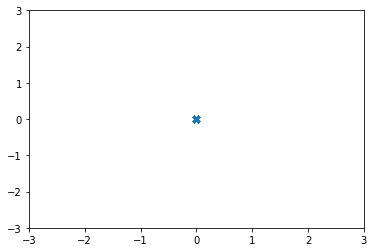

In [26]:
plt.scatter(true_mean.detach().numpy(), approximate_mean.detach().numpy(), marker='x')
plt.xlim(-3, 3)
plt.ylim(-3, 3)
plt.show()

epoch 0 iteration 0 loss 35.578 KL 0.000 weight 0.002 CE 569.250
epoch 0 iteration 100 loss 28.493 KL 0.000 weight 0.002 CE 455.889
epoch 0 iteration 200 loss 30.426 KL 0.000 weight 0.003 CE 486.818
epoch 0 iteration 300 loss 28.264 KL 0.004 weight 0.004 CE 452.217
epoch 0 iteration 400 loss 31.115 KL 0.015 weight 0.005 CE 497.818
epoch 0 iteration 500 loss 28.077 KL 0.010 weight 0.007 CE 449.218
epoch 0 iteration 600 loss 37.557 KL 0.004 weight 0.009 CE 600.902
epoch 0 iteration 700 loss 30.489 KL 0.004 weight 0.011 CE 487.818
epoch 0 iteration 800 loss 32.732 KL 0.004 weight 0.014 CE 523.706
epoch 0 iteration 900 loss 30.763 KL 0.057 weight 0.018 CE 492.152


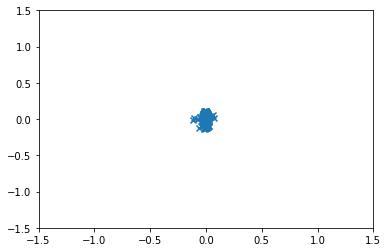

Epoch [1/100], Loss: 33.8232, Perplexity: 488895415478496.94
epoch 1 iteration 1000 loss 35.102 KL 0.000 weight 0.023 CE 561.638
epoch 1 iteration 1100 loss 28.403 KL 0.122 weight 0.029 CE 454.330
epoch 1 iteration 1200 loss 30.410 KL 0.071 weight 0.037 CE 486.483
epoch 1 iteration 1300 loss 27.940 KL 0.598 weight 0.047 CE 446.435
epoch 1 iteration 1400 loss 30.828 KL 1.400 weight 0.060 CE 491.855
epoch 1 iteration 1500 loss 27.348 KL 1.777 weight 0.076 CE 435.795
epoch 1 iteration 1600 loss 35.961 KL 2.659 weight 0.095 CE 572.717
epoch 1 iteration 1700 loss 30.050 KL 2.261 weight 0.119 CE 478.541
epoch 1 iteration 1800 loss 31.482 KL 3.505 weight 0.148 CE 500.206
epoch 1 iteration 1900 loss 30.364 KL 4.244 weight 0.182 CE 481.585


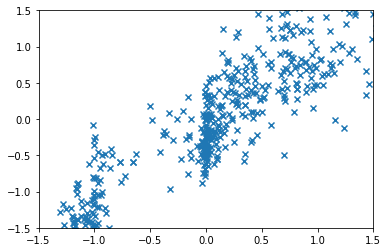

Epoch [2/100], Loss: 32.3232, Perplexity: 109091473781644.06
epoch 2 iteration 2000 loss 34.777 KL 6.060 weight 0.223 CE 550.379
epoch 2 iteration 2100 loss 27.803 KL 5.538 weight 0.269 CE 439.310
epoch 2 iteration 2200 loss 29.806 KL 6.355 weight 0.321 CE 470.543
epoch 2 iteration 2300 loss 27.384 KL 7.514 weight 0.378 CE 430.623
epoch 2 iteration 2400 loss 30.891 KL 9.959 weight 0.438 CE 484.301
epoch 2 iteration 2500 loss 27.684 KL 8.994 weight 0.500 CE 433.951
epoch 2 iteration 2600 loss 36.797 KL 12.287 weight 0.562 CE 576.463
epoch 2 iteration 2700 loss 29.998 KL 8.248 weight 0.622 CE 471.727
epoch 2 iteration 2800 loss 31.602 KL 10.610 weight 0.679 CE 495.015
epoch 2 iteration 2900 loss 30.334 KL 10.779 weight 0.731 CE 474.564


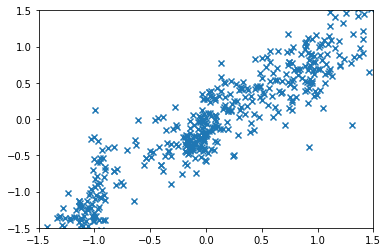

Epoch [3/100], Loss: 32.1195, Perplexity: 88988969414649.98
epoch 3 iteration 3000 loss 35.069 KL 11.268 weight 0.777 CE 549.841
epoch 3 iteration 3100 loss 27.918 KL 9.056 weight 0.818 CE 437.633
epoch 3 iteration 3200 loss 29.758 KL 10.459 weight 0.852 CE 465.677
epoch 3 iteration 3300 loss 27.648 KL 10.944 weight 0.881 CE 431.417
epoch 3 iteration 3400 loss 30.451 KL 11.297 weight 0.905 CE 475.917
epoch 3 iteration 3500 loss 27.906 KL 9.728 weight 0.924 CE 436.764
epoch 3 iteration 3600 loss 36.458 KL 12.457 weight 0.940 CE 570.872
epoch 3 iteration 3700 loss 29.922 KL 7.400 weight 0.953 CE 471.349
epoch 3 iteration 3800 loss 31.699 KL 10.009 weight 0.963 CE 497.172
epoch 3 iteration 3900 loss 31.034 KL 9.159 weight 0.971 CE 487.388


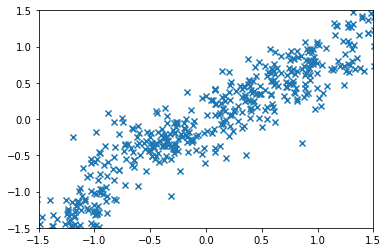

Epoch [4/100], Loss: 31.9267, Perplexity: 73382898660965.70
epoch 4 iteration 4000 loss 34.801 KL 9.573 weight 0.977 CE 547.243
epoch 4 iteration 4100 loss 28.309 KL 8.502 weight 0.982 CE 444.448
epoch 4 iteration 4200 loss 30.156 KL 8.018 weight 0.986 CE 474.486
epoch 4 iteration 4300 loss 27.626 KL 8.294 weight 0.989 CE 433.721
epoch 4 iteration 4400 loss 30.117 KL 9.472 weight 0.991 CE 472.403
epoch 4 iteration 4500 loss 27.433 KL 8.011 weight 0.993 CE 430.909
epoch 4 iteration 4600 loss 36.257 KL 9.656 weight 0.995 CE 570.454
epoch 4 iteration 4700 loss 29.721 KL 6.014 weight 0.996 CE 469.526
epoch 4 iteration 4800 loss 31.376 KL 8.171 weight 0.997 CE 493.842
epoch 4 iteration 4900 loss 30.730 KL 7.518 weight 0.998 CE 484.156


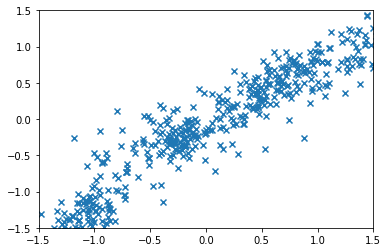

Epoch [5/100], Loss: 32.0075, Perplexity: 79557384500824.19
epoch 5 iteration 5000 loss 35.163 KL 7.958 weight 0.998 CE 554.644
epoch 5 iteration 5100 loss 28.570 KL 8.326 weight 0.998 CE 448.789
epoch 5 iteration 5200 loss 29.661 KL 7.861 weight 0.999 CE 466.709
epoch 5 iteration 5300 loss 27.757 KL 7.929 weight 0.999 CE 436.176
epoch 5 iteration 5400 loss 30.411 KL 8.502 weight 0.999 CE 478.080
epoch 5 iteration 5500 loss 28.030 KL 7.179 weight 0.999 CE 441.308
epoch 5 iteration 5600 loss 36.493 KL 8.920 weight 1.000 CE 574.975
epoch 5 iteration 5700 loss 29.629 KL 6.272 weight 1.000 CE 467.787
epoch 5 iteration 5800 loss 31.198 KL 7.830 weight 1.000 CE 491.335
epoch 5 iteration 5900 loss 30.699 KL 6.855 weight 1.000 CE 484.327


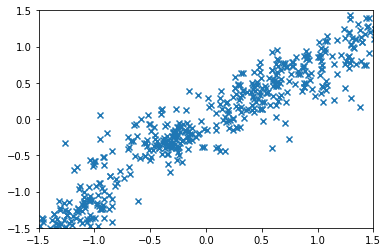

Epoch [6/100], Loss: 31.2047, Perplexity: 35648531870945.23
epoch 6 iteration 6000 loss 34.694 KL 7.703 weight 1.000 CE 547.406
epoch 6 iteration 6100 loss 27.803 KL 7.861 weight 1.000 CE 436.990
epoch 6 iteration 6200 loss 29.503 KL 7.328 weight 1.000 CE 464.713
epoch 6 iteration 6300 loss 27.396 KL 8.292 weight 1.000 CE 430.038
epoch 6 iteration 6400 loss 29.916 KL 7.768 weight 1.000 CE 470.893
epoch 6 iteration 6500 loss 27.832 KL 7.734 weight 1.000 CE 437.585
epoch 6 iteration 6600 loss 35.943 KL 7.354 weight 1.000 CE 567.733
epoch 6 iteration 6700 loss 29.934 KL 5.438 weight 1.000 CE 473.513
epoch 6 iteration 6800 loss 31.132 KL 8.567 weight 1.000 CE 489.553
epoch 6 iteration 6900 loss 30.448 KL 7.897 weight 1.000 CE 479.275


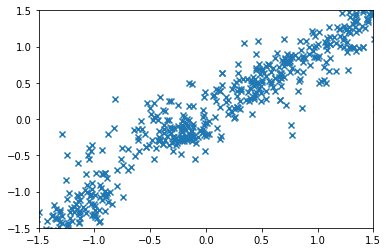

Epoch [7/100], Loss: 31.4080, Perplexity: 43684159439324.46
epoch 7 iteration 7000 loss 34.567 KL 8.467 weight 1.000 CE 544.601
epoch 7 iteration 7100 loss 28.174 KL 8.090 weight 1.000 CE 442.687
epoch 7 iteration 7200 loss 29.724 KL 8.757 weight 1.000 CE 466.832
epoch 7 iteration 7300 loss 27.382 KL 8.037 weight 1.000 CE 430.071
epoch 7 iteration 7400 loss 29.898 KL 8.468 weight 1.000 CE 469.894
epoch 7 iteration 7500 loss 27.986 KL 7.403 weight 1.000 CE 440.370
epoch 7 iteration 7600 loss 36.114 KL 8.294 weight 1.000 CE 569.529
epoch 7 iteration 7700 loss 29.870 KL 5.883 weight 1.000 CE 472.031
epoch 7 iteration 7800 loss 30.987 KL 8.755 weight 1.000 CE 487.033
epoch 7 iteration 7900 loss 30.363 KL 7.864 weight 1.000 CE 477.951


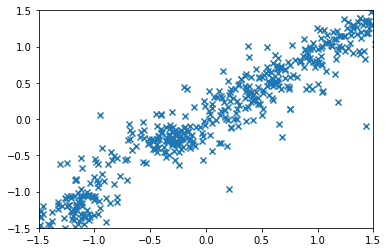

Epoch [8/100], Loss: 31.0586, Perplexity: 30803429766440.62
epoch 8 iteration 8000 loss 34.549 KL 8.043 weight 1.000 CE 544.737
epoch 8 iteration 8100 loss 27.503 KL 7.507 weight 1.000 CE 432.546
epoch 8 iteration 8200 loss 29.509 KL 7.381 weight 1.000 CE 464.770
epoch 8 iteration 8300 loss 27.082 KL 7.786 weight 1.000 CE 425.528
epoch 8 iteration 8400 loss 29.144 KL 7.840 weight 1.000 CE 458.457
epoch 8 iteration 8500 loss 27.683 KL 6.711 weight 1.000 CE 436.218
epoch 8 iteration 8600 loss 36.177 KL 8.598 weight 1.000 CE 570.228
epoch 8 iteration 8700 loss 30.230 KL 5.589 weight 1.000 CE 478.096
epoch 8 iteration 8800 loss 30.808 KL 7.832 weight 1.000 CE 485.098
epoch 8 iteration 8900 loss 30.067 KL 7.686 weight 1.000 CE 473.379


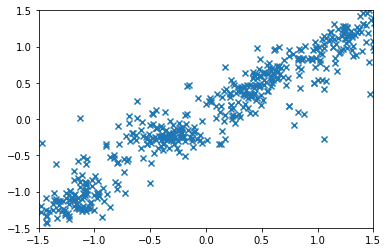

Epoch [9/100], Loss: 30.8723, Perplexity: 25567352007608.23
epoch 9 iteration 9000 loss 34.242 KL 7.353 weight 1.000 CE 540.511
epoch 9 iteration 9100 loss 27.551 KL 7.740 weight 1.000 CE 433.075
epoch 9 iteration 9200 loss 29.559 KL 8.240 weight 1.000 CE 464.700
epoch 9 iteration 9300 loss 26.845 KL 7.406 weight 1.000 CE 422.119
epoch 9 iteration 9400 loss 29.123 KL 7.978 weight 1.000 CE 457.983
epoch 9 iteration 9500 loss 27.644 KL 7.778 weight 1.000 CE 434.531
epoch 9 iteration 9600 loss 35.614 KL 8.294 weight 1.000 CE 561.522
epoch 9 iteration 9700 loss 29.799 KL 6.066 weight 1.000 CE 470.723
epoch 9 iteration 9800 loss 30.638 KL 8.021 weight 1.000 CE 482.179
epoch 9 iteration 9900 loss 29.910 KL 7.550 weight 1.000 CE 471.002


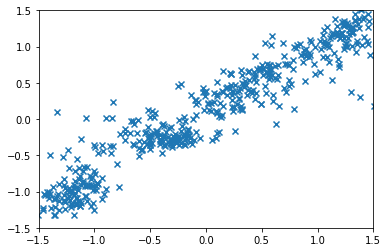

Epoch [10/100], Loss: 31.1833, Perplexity: 34891945485738.97
epoch 10 iteration 10000 loss 34.917 KL 7.263 weight 1.000 CE 551.417
epoch 10 iteration 10100 loss 27.422 KL 7.786 weight 1.000 CE 430.960
epoch 10 iteration 10200 loss 29.607 KL 7.748 weight 1.000 CE 465.961
epoch 10 iteration 10300 loss 26.928 KL 9.237 weight 1.000 CE 421.614
epoch 10 iteration 10400 loss 29.280 KL 7.080 weight 1.000 CE 461.402
epoch 10 iteration 10500 loss 27.702 KL 7.262 weight 1.000 CE 435.977
epoch 10 iteration 10600 loss 35.968 KL 8.153 weight 1.000 CE 567.328
epoch 10 iteration 10700 loss 29.673 KL 5.354 weight 1.000 CE 469.409
epoch 10 iteration 10800 loss 30.172 KL 8.536 weight 1.000 CE 474.211
epoch 10 iteration 10900 loss 30.140 KL 7.843 weight 1.000 CE 474.397


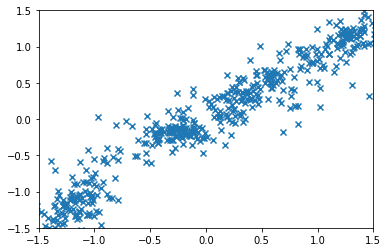

Epoch [11/100], Loss: 30.3152, Perplexity: 14645455735932.38
epoch 11 iteration 11000 loss 34.357 KL 7.994 weight 1.000 CE 541.719
epoch 11 iteration 11100 loss 27.714 KL 7.652 weight 1.000 CE 435.779
epoch 11 iteration 11200 loss 29.506 KL 7.537 weight 1.000 CE 464.567
epoch 11 iteration 11300 loss 26.869 KL 8.060 weight 1.000 CE 421.851
epoch 11 iteration 11400 loss 28.841 KL 8.389 weight 1.000 CE 453.074
epoch 11 iteration 11500 loss 27.496 KL 7.581 weight 1.000 CE 432.356
epoch 11 iteration 11600 loss 35.803 KL 8.117 weight 1.000 CE 564.735
epoch 11 iteration 11700 loss 29.639 KL 5.813 weight 1.000 CE 468.418
epoch 11 iteration 11800 loss 30.354 KL 8.854 weight 1.000 CE 476.810
epoch 11 iteration 11900 loss 30.398 KL 7.830 weight 1.000 CE 478.536


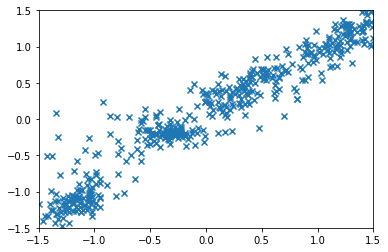

Epoch [12/100], Loss: 30.6611, Perplexity: 20699268161532.96
epoch 12 iteration 12000 loss 34.436 KL 8.230 weight 1.000 CE 542.750
epoch 12 iteration 12100 loss 27.520 KL 8.353 weight 1.000 CE 431.967
epoch 12 iteration 12200 loss 29.278 KL 8.623 weight 1.000 CE 459.819
epoch 12 iteration 12300 loss 26.594 KL 7.790 weight 1.000 CE 417.711
epoch 12 iteration 12400 loss 28.601 KL 8.171 weight 1.000 CE 449.447
epoch 12 iteration 12500 loss 27.297 KL 7.793 weight 1.000 CE 428.964
epoch 12 iteration 12600 loss 35.743 KL 9.107 weight 1.000 CE 562.779
epoch 12 iteration 12700 loss 29.236 KL 6.660 weight 1.000 CE 461.113
epoch 12 iteration 12800 loss 30.496 KL 8.316 weight 1.000 CE 479.622
epoch 12 iteration 12900 loss 29.972 KL 8.454 weight 1.000 CE 471.100


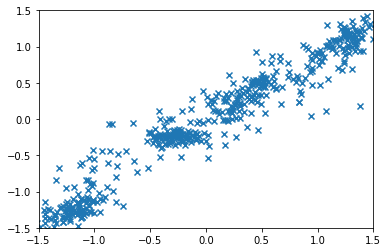

Epoch [13/100], Loss: 30.4096, Perplexity: 16096088319070.10
epoch 13 iteration 13000 loss 34.368 KL 8.311 weight 1.000 CE 541.581
epoch 13 iteration 13100 loss 27.333 KL 8.190 weight 1.000 CE 429.131
epoch 13 iteration 13200 loss 28.982 KL 8.060 weight 1.000 CE 455.659
epoch 13 iteration 13300 loss 26.568 KL 8.249 weight 1.000 CE 416.835
epoch 13 iteration 13400 loss 29.049 KL 9.678 weight 1.000 CE 455.104
epoch 13 iteration 13500 loss 27.714 KL 7.240 weight 1.000 CE 436.184
epoch 13 iteration 13600 loss 35.386 KL 8.430 weight 1.000 CE 557.751
epoch 13 iteration 13700 loss 29.348 KL 5.700 weight 1.000 CE 463.865
epoch 13 iteration 13800 loss 30.493 KL 8.023 weight 1.000 CE 479.866
epoch 13 iteration 13900 loss 29.864 KL 8.473 weight 1.000 CE 469.347


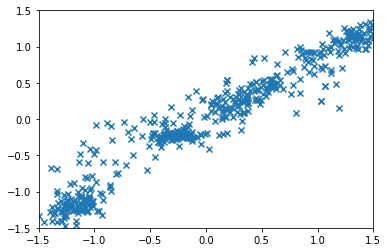

Epoch [14/100], Loss: 30.3339, Perplexity: 14922893374351.67
epoch 14 iteration 14000 loss 34.548 KL 7.586 weight 1.000 CE 545.174
epoch 14 iteration 14100 loss 27.307 KL 7.532 weight 1.000 CE 429.377
epoch 14 iteration 14200 loss 29.341 KL 7.706 weight 1.000 CE 461.752
epoch 14 iteration 14300 loss 26.337 KL 7.822 weight 1.000 CE 413.562
epoch 14 iteration 14400 loss 29.734 KL 8.210 weight 1.000 CE 467.531
epoch 14 iteration 14500 loss 27.225 KL 7.543 weight 1.000 CE 428.054
epoch 14 iteration 14600 loss 35.428 KL 8.643 weight 1.000 CE 558.209
epoch 14 iteration 14700 loss 29.714 KL 6.787 weight 1.000 CE 468.631
epoch 14 iteration 14800 loss 30.148 KL 9.855 weight 1.000 CE 472.509
epoch 14 iteration 14900 loss 29.795 KL 8.397 weight 1.000 CE 468.322


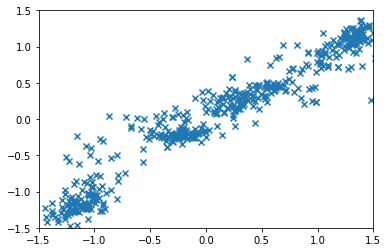

Epoch [15/100], Loss: 30.7400, Perplexity: 22398498244979.18
epoch 15 iteration 15000 loss 34.017 KL 7.443 weight 1.000 CE 536.821
epoch 15 iteration 15100 loss 26.880 KL 8.097 weight 1.000 CE 421.975
epoch 15 iteration 15200 loss 29.084 KL 8.414 weight 1.000 CE 456.927
epoch 15 iteration 15300 loss 26.598 KL 8.408 weight 1.000 CE 417.166
epoch 15 iteration 15400 loss 28.556 KL 8.402 weight 1.000 CE 448.499
epoch 15 iteration 15500 loss 27.619 KL 6.988 weight 1.000 CE 434.921
epoch 15 iteration 15600 loss 35.447 KL 7.562 weight 1.000 CE 559.584
epoch 15 iteration 15700 loss 29.310 KL 5.356 weight 1.000 CE 463.602
epoch 15 iteration 15800 loss 30.763 KL 6.900 weight 1.000 CE 485.304
epoch 15 iteration 15900 loss 29.625 KL 6.943 weight 1.000 CE 467.058


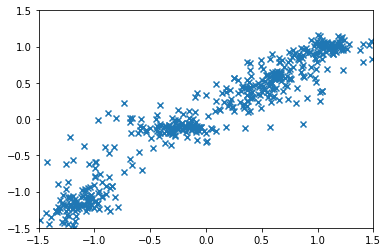

Epoch [16/100], Loss: 30.2745, Perplexity: 14062654214634.02
epoch 16 iteration 16000 loss 33.844 KL 6.562 weight 1.000 CE 534.947
epoch 16 iteration 16100 loss 26.728 KL 7.184 weight 1.000 CE 420.471
epoch 16 iteration 16200 loss 29.039 KL 6.232 weight 1.000 CE 458.397
epoch 16 iteration 16300 loss 26.743 KL 6.551 weight 1.000 CE 421.339
epoch 16 iteration 16400 loss 28.211 KL 7.561 weight 1.000 CE 443.817
epoch 16 iteration 16500 loss 27.815 KL 7.213 weight 1.000 CE 437.826
epoch 16 iteration 16600 loss 35.074 KL 6.492 weight 1.000 CE 554.694
epoch 16 iteration 16700 loss 29.037 KL 5.217 weight 1.000 CE 459.368
epoch 16 iteration 16800 loss 30.580 KL 6.265 weight 1.000 CE 483.019
epoch 16 iteration 16900 loss 29.511 KL 6.679 weight 1.000 CE 465.501


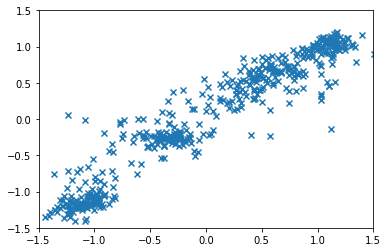

Epoch [17/100], Loss: 30.8348, Perplexity: 24625851630109.80
epoch 17 iteration 17000 loss 34.009 KL 6.643 weight 1.000 CE 537.500
epoch 17 iteration 17100 loss 26.976 KL 6.854 weight 1.000 CE 424.762
epoch 17 iteration 17200 loss 29.349 KL 6.982 weight 1.000 CE 462.607
epoch 17 iteration 17300 loss 26.156 KL 6.348 weight 1.000 CE 412.151
epoch 17 iteration 17400 loss 28.510 KL 8.210 weight 1.000 CE 447.943
epoch 17 iteration 17500 loss 27.572 KL 6.163 weight 1.000 CE 434.996
epoch 17 iteration 17600 loss 35.103 KL 6.618 weight 1.000 CE 555.023
epoch 17 iteration 17700 loss 29.284 KL 5.686 weight 1.000 CE 462.854
epoch 17 iteration 17800 loss 29.935 KL 7.273 weight 1.000 CE 471.682
epoch 17 iteration 17900 loss 29.609 KL 7.427 weight 1.000 CE 466.316


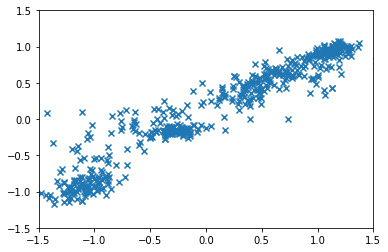

Epoch [18/100], Loss: 30.3075, Perplexity: 14533978603839.54
epoch 18 iteration 18000 loss 34.225 KL 5.379 weight 1.000 CE 542.220
epoch 18 iteration 18100 loss 26.703 KL 7.312 weight 1.000 CE 419.933
epoch 18 iteration 18200 loss 29.029 KL 6.672 weight 1.000 CE 457.793
epoch 18 iteration 18300 loss 26.311 KL 6.003 weight 1.000 CE 414.978
epoch 18 iteration 18400 loss 28.270 KL 8.498 weight 1.000 CE 443.830
epoch 18 iteration 18500 loss 27.656 KL 6.281 weight 1.000 CE 436.220
epoch 18 iteration 18600 loss 35.037 KL 7.075 weight 1.000 CE 553.523
epoch 18 iteration 18700 loss 29.352 KL 6.484 weight 1.000 CE 463.143
epoch 18 iteration 18800 loss 30.097 KL 8.362 weight 1.000 CE 473.188
epoch 18 iteration 18900 loss 29.591 KL 7.470 weight 1.000 CE 465.993


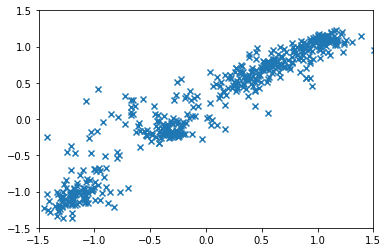

Epoch [19/100], Loss: 30.2273, Perplexity: 13413586133820.13
epoch 19 iteration 19000 loss 34.232 KL 7.099 weight 1.000 CE 540.609
epoch 19 iteration 19100 loss 26.764 KL 7.327 weight 1.000 CE 420.903
epoch 19 iteration 19200 loss 28.804 KL 5.918 weight 1.000 CE 454.939
epoch 19 iteration 19300 loss 26.428 KL 6.328 weight 1.000 CE 416.519
epoch 19 iteration 19400 loss 28.281 KL 7.722 weight 1.000 CE 444.777
epoch 19 iteration 19500 loss 27.492 KL 6.413 weight 1.000 CE 433.466
epoch 19 iteration 19600 loss 35.467 KL 7.438 weight 1.000 CE 560.040
epoch 19 iteration 19700 loss 29.660 KL 5.526 weight 1.000 CE 469.041
epoch 19 iteration 19800 loss 29.794 KL 7.634 weight 1.000 CE 469.063
epoch 19 iteration 19900 loss 29.438 KL 7.401 weight 1.000 CE 463.612


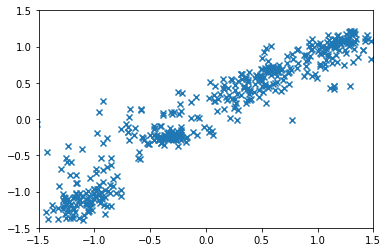

Epoch [20/100], Loss: 30.1261, Perplexity: 12123205015460.22
epoch 20 iteration 20000 loss 33.674 KL 7.155 weight 1.000 CE 531.635
epoch 20 iteration 20100 loss 26.982 KL 8.340 weight 1.000 CE 423.369
epoch 20 iteration 20200 loss 29.001 KL 6.817 weight 1.000 CE 457.196
epoch 20 iteration 20300 loss 26.310 KL 7.306 weight 1.000 CE 413.648
epoch 20 iteration 20400 loss 28.280 KL 7.913 weight 1.000 CE 444.569
epoch 20 iteration 20500 loss 27.216 KL 7.137 weight 1.000 CE 428.315
epoch 20 iteration 20600 loss 34.661 KL 7.392 weight 1.000 CE 547.188
epoch 20 iteration 20700 loss 28.884 KL 5.826 weight 1.000 CE 456.321
epoch 20 iteration 20800 loss 30.076 KL 8.961 weight 1.000 CE 472.254
epoch 20 iteration 20900 loss 29.344 KL 7.875 weight 1.000 CE 461.627


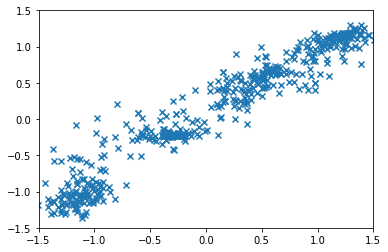

Epoch [21/100], Loss: 29.7853, Perplexity: 8621335803270.11
epoch 21 iteration 21000 loss 33.998 KL 6.909 weight 1.000 CE 537.055
epoch 21 iteration 21100 loss 26.707 KL 7.214 weight 1.000 CE 420.094
epoch 21 iteration 21200 loss 29.000 KL 8.241 weight 1.000 CE 455.764
epoch 21 iteration 21300 loss 26.128 KL 7.406 weight 1.000 CE 410.645
epoch 21 iteration 21400 loss 28.446 KL 6.744 weight 1.000 CE 448.398
epoch 21 iteration 21500 loss 27.345 KL 6.715 weight 1.000 CE 430.804
epoch 21 iteration 21600 loss 34.952 KL 7.578 weight 1.000 CE 551.649
epoch 21 iteration 21700 loss 28.896 KL 6.200 weight 1.000 CE 456.133
epoch 21 iteration 21800 loss 30.231 KL 8.241 weight 1.000 CE 475.450
epoch 21 iteration 21900 loss 29.350 KL 8.010 weight 1.000 CE 461.593


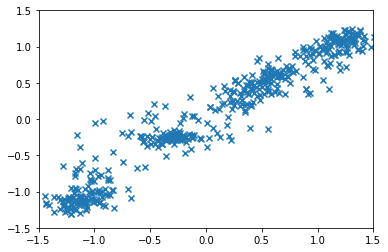

Epoch [22/100], Loss: 30.0357, Perplexity: 11075104031679.98
epoch 22 iteration 22000 loss 34.764 KL 6.528 weight 1.000 CE 549.699
epoch 22 iteration 22100 loss 26.565 KL 7.722 weight 1.000 CE 417.326
epoch 22 iteration 22200 loss 29.017 KL 7.463 weight 1.000 CE 456.808
epoch 22 iteration 22300 loss 26.144 KL 7.579 weight 1.000 CE 410.725
epoch 22 iteration 22400 loss 28.212 KL 7.327 weight 1.000 CE 444.059
epoch 22 iteration 22500 loss 27.302 KL 6.946 weight 1.000 CE 429.880
epoch 22 iteration 22600 loss 35.082 KL 7.651 weight 1.000 CE 553.662
epoch 22 iteration 22700 loss 28.878 KL 6.734 weight 1.000 CE 455.306
epoch 22 iteration 22800 loss 30.028 KL 7.993 weight 1.000 CE 472.459
epoch 22 iteration 22900 loss 29.417 KL 7.268 weight 1.000 CE 463.404


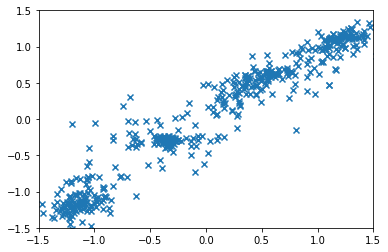

Epoch [23/100], Loss: 30.1383, Perplexity: 12271257664344.51
epoch 23 iteration 23000 loss 33.839 KL 7.394 weight 1.000 CE 534.033
epoch 23 iteration 23100 loss 26.600 KL 7.550 weight 1.000 CE 418.053
epoch 23 iteration 23200 loss 28.722 KL 7.230 weight 1.000 CE 452.318
epoch 23 iteration 23300 loss 26.313 KL 8.349 weight 1.000 CE 412.654
epoch 23 iteration 23400 loss 28.568 KL 8.561 weight 1.000 CE 448.523
epoch 23 iteration 23500 loss 27.441 KL 7.509 weight 1.000 CE 431.544
epoch 23 iteration 23600 loss 34.839 KL 8.199 weight 1.000 CE 549.221
epoch 23 iteration 23700 loss 29.271 KL 6.102 weight 1.000 CE 462.234
epoch 23 iteration 23800 loss 30.269 KL 8.907 weight 1.000 CE 475.400
epoch 23 iteration 23900 loss 29.590 KL 7.950 weight 1.000 CE 465.492


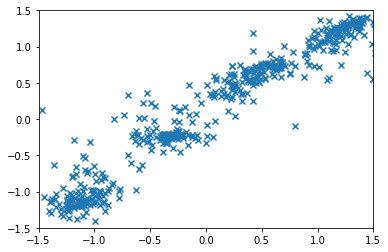

Epoch [24/100], Loss: 29.5559, Perplexity: 6854257013412.51
epoch 24 iteration 24000 loss 33.770 KL 7.714 weight 1.000 CE 532.607
epoch 24 iteration 24100 loss 26.701 KL 8.011 weight 1.000 CE 419.207
epoch 24 iteration 24200 loss 28.918 KL 7.421 weight 1.000 CE 455.274
epoch 24 iteration 24300 loss 26.344 KL 7.450 weight 1.000 CE 414.058
epoch 24 iteration 24400 loss 27.976 KL 8.297 weight 1.000 CE 439.323
epoch 24 iteration 24500 loss 27.084 KL 7.496 weight 1.000 CE 425.849
epoch 24 iteration 24600 loss 35.039 KL 7.890 weight 1.000 CE 552.736
epoch 24 iteration 24700 loss 28.661 KL 6.326 weight 1.000 CE 452.252
epoch 24 iteration 24800 loss 30.415 KL 9.042 weight 1.000 CE 477.591
epoch 24 iteration 24900 loss 29.531 KL 7.869 weight 1.000 CE 464.634


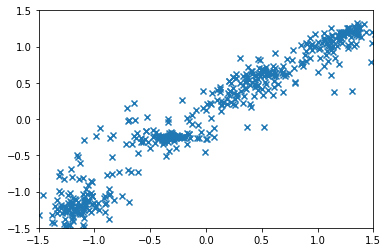

Epoch [25/100], Loss: 29.8548, Perplexity: 9242165755874.97
epoch 25 iteration 25000 loss 33.873 KL 7.849 weight 1.000 CE 534.124
epoch 25 iteration 25100 loss 26.683 KL 7.855 weight 1.000 CE 419.074
epoch 25 iteration 25200 loss 28.911 KL 7.602 weight 1.000 CE 454.971
epoch 25 iteration 25300 loss 26.269 KL 7.587 weight 1.000 CE 412.720
epoch 25 iteration 25400 loss 28.204 KL 8.068 weight 1.000 CE 443.202
epoch 25 iteration 25500 loss 26.894 KL 8.168 weight 1.000 CE 422.130
epoch 25 iteration 25600 loss 34.547 KL 7.876 weight 1.000 CE 544.869
epoch 25 iteration 25700 loss 28.662 KL 6.541 weight 1.000 CE 452.049
epoch 25 iteration 25800 loss 29.967 KL 8.840 weight 1.000 CE 470.630
epoch 25 iteration 25900 loss 29.715 KL 8.641 weight 1.000 CE 466.793


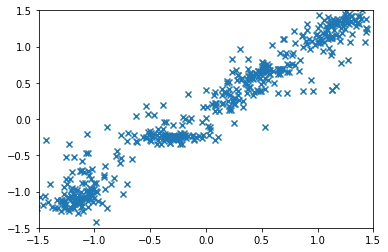

Epoch [26/100], Loss: 29.5959, Perplexity: 7134195188046.17
epoch 26 iteration 26000 loss 33.728 KL 8.080 weight 1.000 CE 531.574
epoch 26 iteration 26100 loss 26.868 KL 8.346 weight 1.000 CE 421.546
epoch 26 iteration 26200 loss 28.773 KL 7.751 weight 1.000 CE 452.617
epoch 26 iteration 26300 loss 25.843 KL 8.116 weight 1.000 CE 405.368
epoch 26 iteration 26400 loss 28.550 KL 8.807 weight 1.000 CE 447.985
epoch 26 iteration 26500 loss 26.889 KL 7.988 weight 1.000 CE 422.237
epoch 26 iteration 26600 loss 34.116 KL 7.562 weight 1.000 CE 538.292
epoch 26 iteration 26700 loss 28.877 KL 6.222 weight 1.000 CE 455.816
epoch 26 iteration 26800 loss 30.363 KL 8.852 weight 1.000 CE 476.948
epoch 26 iteration 26900 loss 29.747 KL 8.634 weight 1.000 CE 467.324


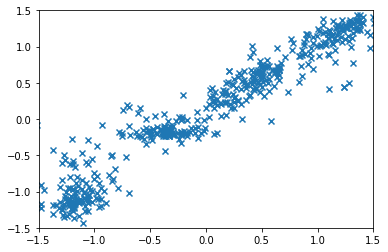

Epoch [27/100], Loss: 29.6881, Perplexity: 7822971269293.43
epoch 27 iteration 27000 loss 33.781 KL 7.731 weight 1.000 CE 532.770
epoch 27 iteration 27100 loss 26.354 KL 7.867 weight 1.000 CE 413.793
epoch 27 iteration 27200 loss 28.919 KL 7.540 weight 1.000 CE 455.156
epoch 27 iteration 27300 loss 25.868 KL 8.250 weight 1.000 CE 405.630
epoch 27 iteration 27400 loss 28.628 KL 7.507 weight 1.000 CE 450.537
epoch 27 iteration 27500 loss 27.240 KL 8.162 weight 1.000 CE 427.682
epoch 27 iteration 27600 loss 34.277 KL 7.554 weight 1.000 CE 540.876
epoch 27 iteration 27700 loss 28.548 KL 5.547 weight 1.000 CE 451.215
epoch 27 iteration 27800 loss 29.764 KL 8.680 weight 1.000 CE 467.550
epoch 27 iteration 27900 loss 29.419 KL 8.262 weight 1.000 CE 462.435


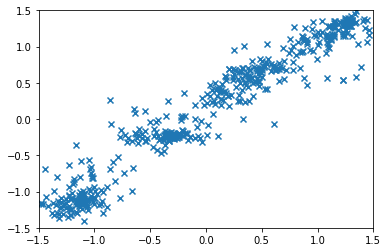

Epoch [28/100], Loss: 29.4144, Perplexity: 5950006644144.70
epoch 28 iteration 28000 loss 33.709 KL 8.330 weight 1.000 CE 531.019
epoch 28 iteration 28100 loss 26.745 KL 8.405 weight 1.000 CE 419.518
epoch 28 iteration 28200 loss 28.916 KL 7.847 weight 1.000 CE 454.806
epoch 28 iteration 28300 loss 25.744 KL 6.794 weight 1.000 CE 405.102
epoch 28 iteration 28400 loss 28.345 KL 7.845 weight 1.000 CE 445.675
epoch 28 iteration 28500 loss 27.014 KL 7.393 weight 1.000 CE 424.831
epoch 28 iteration 28600 loss 34.658 KL 8.025 weight 1.000 CE 546.502
epoch 28 iteration 28700 loss 28.244 KL 6.747 weight 1.000 CE 445.153
epoch 28 iteration 28800 loss 30.528 KL 9.605 weight 1.000 CE 478.846
epoch 28 iteration 28900 loss 29.266 KL 7.493 weight 1.000 CE 460.762


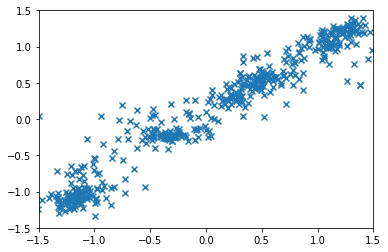

Epoch [29/100], Loss: 30.0027, Perplexity: 10714987369014.90
epoch 29 iteration 29000 loss 34.216 KL 7.261 weight 1.000 CE 540.201
epoch 29 iteration 29100 loss 26.873 KL 7.030 weight 1.000 CE 422.936
epoch 29 iteration 29200 loss 28.569 KL 8.011 weight 1.000 CE 449.096
epoch 29 iteration 29300 loss 25.701 KL 7.986 weight 1.000 CE 403.229
epoch 29 iteration 29400 loss 28.865 KL 8.030 weight 1.000 CE 453.811
epoch 29 iteration 29500 loss 26.901 KL 7.154 weight 1.000 CE 423.259
epoch 29 iteration 29600 loss 34.366 KL 7.618 weight 1.000 CE 542.242
epoch 29 iteration 29700 loss 28.581 KL 5.664 weight 1.000 CE 451.625
epoch 29 iteration 29800 loss 30.067 KL 9.851 weight 1.000 CE 471.213
epoch 29 iteration 29900 loss 29.595 KL 8.361 weight 1.000 CE 465.158


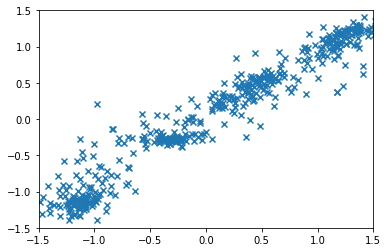

Epoch [30/100], Loss: 29.5723, Perplexity: 6967762120621.73
epoch 30 iteration 30000 loss 33.928 KL 7.471 weight 1.000 CE 535.372
epoch 30 iteration 30100 loss 26.921 KL 8.115 weight 1.000 CE 422.626
epoch 30 iteration 30200 loss 28.833 KL 6.855 weight 1.000 CE 454.465
epoch 30 iteration 30300 loss 25.888 KL 7.891 weight 1.000 CE 406.321
epoch 30 iteration 30400 loss 28.201 KL 7.760 weight 1.000 CE 443.454
epoch 30 iteration 30500 loss 27.351 KL 7.514 weight 1.000 CE 430.096
epoch 30 iteration 30600 loss 34.224 KL 7.563 weight 1.000 CE 540.016
epoch 30 iteration 30700 loss 28.325 KL 6.388 weight 1.000 CE 446.813
epoch 30 iteration 30800 loss 30.053 KL 8.654 weight 1.000 CE 472.186
epoch 30 iteration 30900 loss 29.352 KL 7.934 weight 1.000 CE 461.695


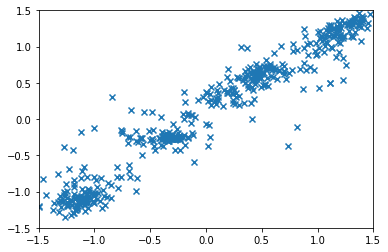

Epoch [31/100], Loss: 29.3432, Perplexity: 5541183897812.12
epoch 31 iteration 31000 loss 33.302 KL 8.273 weight 1.000 CE 524.556
epoch 31 iteration 31100 loss 27.377 KL 7.922 weight 1.000 CE 430.103
epoch 31 iteration 31200 loss 28.514 KL 7.601 weight 1.000 CE 448.629
epoch 31 iteration 31300 loss 25.403 KL 8.269 weight 1.000 CE 398.184
epoch 31 iteration 31400 loss 28.587 KL 7.647 weight 1.000 CE 449.745
epoch 31 iteration 31500 loss 26.979 KL 7.854 weight 1.000 CE 423.809
epoch 31 iteration 31600 loss 34.126 KL 7.816 weight 1.000 CE 538.198
epoch 31 iteration 31700 loss 28.690 KL 6.434 weight 1.000 CE 452.611
epoch 31 iteration 31800 loss 30.049 KL 8.745 weight 1.000 CE 472.031
epoch 31 iteration 31900 loss 29.320 KL 7.647 weight 1.000 CE 461.477


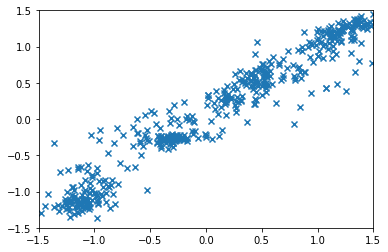

Epoch [32/100], Loss: 29.5828, Perplexity: 7041295316110.75
epoch 32 iteration 32000 loss 33.804 KL 7.855 weight 1.000 CE 533.016
epoch 32 iteration 32100 loss 26.854 KL 7.349 weight 1.000 CE 422.308
epoch 32 iteration 32200 loss 28.581 KL 8.712 weight 1.000 CE 448.590
epoch 32 iteration 32300 loss 25.617 KL 7.076 weight 1.000 CE 402.802
epoch 32 iteration 32400 loss 29.103 KL 8.175 weight 1.000 CE 457.475
epoch 32 iteration 32500 loss 27.052 KL 7.595 weight 1.000 CE 425.232
epoch 32 iteration 32600 loss 34.192 KL 7.927 weight 1.000 CE 539.152
epoch 32 iteration 32700 loss 28.514 KL 5.649 weight 1.000 CE 450.569
epoch 32 iteration 32800 loss 30.093 KL 10.073 weight 1.000 CE 471.416
epoch 32 iteration 32900 loss 29.342 KL 7.647 weight 1.000 CE 461.821


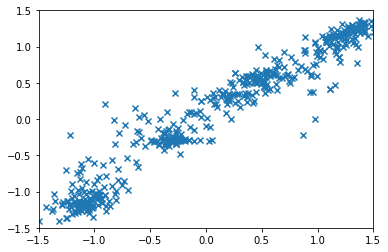

Epoch [33/100], Loss: 29.2769, Perplexity: 5185700452867.75
epoch 33 iteration 33000 loss 33.508 KL 7.530 weight 1.000 CE 528.598
epoch 33 iteration 33100 loss 26.802 KL 7.975 weight 1.000 CE 420.854
epoch 33 iteration 33200 loss 28.511 KL 8.288 weight 1.000 CE 447.893
epoch 33 iteration 33300 loss 25.564 KL 7.440 weight 1.000 CE 401.579
epoch 33 iteration 33400 loss 28.692 KL 7.667 weight 1.000 CE 451.397
epoch 33 iteration 33500 loss 27.062 KL 7.454 weight 1.000 CE 425.536
epoch 33 iteration 33600 loss 33.706 KL 8.166 weight 1.000 CE 531.129
epoch 33 iteration 33700 loss 28.086 KL 6.589 weight 1.000 CE 442.793
epoch 33 iteration 33800 loss 29.653 KL 7.906 weight 1.000 CE 466.547
epoch 33 iteration 33900 loss 29.157 KL 7.661 weight 1.000 CE 458.853


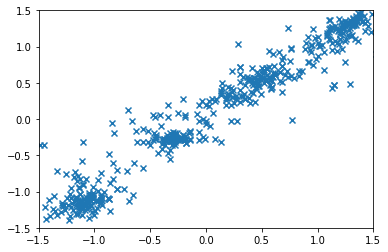

Epoch [34/100], Loss: 29.2042, Perplexity: 4821928282423.34
epoch 34 iteration 34000 loss 33.738 KL 7.908 weight 1.000 CE 531.902
epoch 34 iteration 34100 loss 26.710 KL 8.017 weight 1.000 CE 419.346
epoch 34 iteration 34200 loss 28.701 KL 7.270 weight 1.000 CE 451.942
epoch 34 iteration 34300 loss 25.449 KL 7.033 weight 1.000 CE 400.155
epoch 34 iteration 34400 loss 28.759 KL 8.261 weight 1.000 CE 451.890
epoch 34 iteration 34500 loss 27.182 KL 6.917 weight 1.000 CE 427.997
epoch 34 iteration 34600 loss 34.074 KL 7.320 weight 1.000 CE 537.861
epoch 34 iteration 34700 loss 28.052 KL 6.177 weight 1.000 CE 442.661
epoch 34 iteration 34800 loss 29.782 KL 8.655 weight 1.000 CE 467.854
epoch 34 iteration 34900 loss 29.279 KL 7.119 weight 1.000 CE 461.344


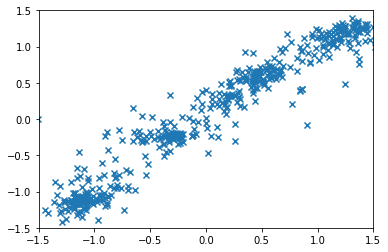

Epoch [35/100], Loss: 29.3228, Perplexity: 5429159255596.91
epoch 35 iteration 35000 loss 33.581 KL 7.519 weight 1.000 CE 529.780
epoch 35 iteration 35100 loss 27.268 KL 8.266 weight 1.000 CE 428.015
epoch 35 iteration 35200 loss 28.689 KL 8.107 weight 1.000 CE 450.921
epoch 35 iteration 35300 loss 25.391 KL 6.898 weight 1.000 CE 399.352
epoch 35 iteration 35400 loss 28.580 KL 7.839 weight 1.000 CE 449.446
epoch 35 iteration 35500 loss 26.782 KL 7.637 weight 1.000 CE 420.881
epoch 35 iteration 35600 loss 33.874 KL 7.908 weight 1.000 CE 534.069
epoch 35 iteration 35700 loss 28.300 KL 6.042 weight 1.000 CE 446.758
epoch 35 iteration 35800 loss 29.649 KL 9.531 weight 1.000 CE 464.848
epoch 35 iteration 35900 loss 29.147 KL 7.796 weight 1.000 CE 458.548


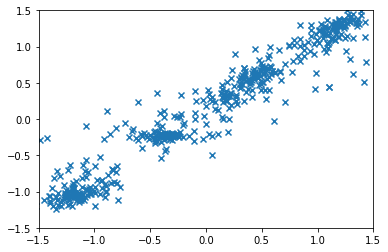

Epoch [36/100], Loss: 28.8948, Perplexity: 3538648016496.90
epoch 36 iteration 36000 loss 33.186 KL 7.982 weight 1.000 CE 522.996
epoch 36 iteration 36100 loss 26.818 KL 7.328 weight 1.000 CE 421.766
epoch 36 iteration 36200 loss 28.312 KL 7.307 weight 1.000 CE 445.683
epoch 36 iteration 36300 loss 25.433 KL 6.808 weight 1.000 CE 400.127
epoch 36 iteration 36400 loss 28.253 KL 7.578 weight 1.000 CE 444.477
epoch 36 iteration 36500 loss 26.769 KL 7.148 weight 1.000 CE 421.160
epoch 36 iteration 36600 loss 33.834 KL 7.240 weight 1.000 CE 534.103
epoch 36 iteration 36700 loss 28.337 KL 6.090 weight 1.000 CE 447.297
epoch 36 iteration 36800 loss 29.690 KL 8.371 weight 1.000 CE 466.674
epoch 36 iteration 36900 loss 29.433 KL 6.984 weight 1.000 CE 463.944


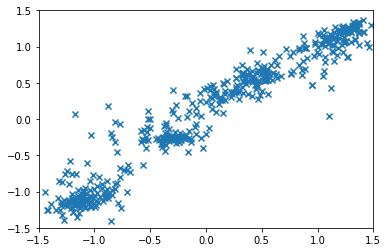

Epoch [37/100], Loss: 28.9406, Perplexity: 3704759631743.50
epoch 37 iteration 37000 loss 33.241 KL 7.354 weight 1.000 CE 524.508
epoch 37 iteration 37100 loss 26.832 KL 7.792 weight 1.000 CE 421.514
epoch 37 iteration 37200 loss 28.273 KL 7.473 weight 1.000 CE 444.887
epoch 37 iteration 37300 loss 25.364 KL 7.537 weight 1.000 CE 398.283
epoch 37 iteration 37400 loss 28.406 KL 8.397 weight 1.000 CE 446.096
epoch 37 iteration 37500 loss 27.391 KL 7.933 weight 1.000 CE 430.317
epoch 37 iteration 37600 loss 33.901 KL 8.221 weight 1.000 CE 534.188
epoch 37 iteration 37700 loss 27.887 KL 6.595 weight 1.000 CE 439.603
epoch 37 iteration 37800 loss 29.957 KL 9.634 weight 1.000 CE 469.680
epoch 37 iteration 37900 loss 29.206 KL 7.669 weight 1.000 CE 459.627


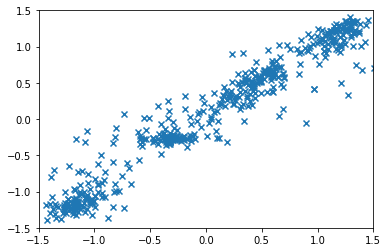

Epoch [38/100], Loss: 29.1930, Perplexity: 4768324266277.83
epoch 38 iteration 38000 loss 33.311 KL 7.954 weight 1.000 CE 525.016
epoch 38 iteration 38100 loss 26.783 KL 7.424 weight 1.000 CE 421.099
epoch 38 iteration 38200 loss 28.320 KL 7.448 weight 1.000 CE 445.671
epoch 38 iteration 38300 loss 25.569 KL 7.141 weight 1.000 CE 401.959
epoch 38 iteration 38400 loss 28.392 KL 8.826 weight 1.000 CE 445.444
epoch 38 iteration 38500 loss 26.579 KL 7.397 weight 1.000 CE 417.862
epoch 38 iteration 38600 loss 33.964 KL 7.338 weight 1.000 CE 536.082
epoch 38 iteration 38700 loss 28.014 KL 5.632 weight 1.000 CE 442.593
epoch 38 iteration 38800 loss 30.285 KL 9.443 weight 1.000 CE 475.110
epoch 38 iteration 38900 loss 29.441 KL 8.242 weight 1.000 CE 462.821


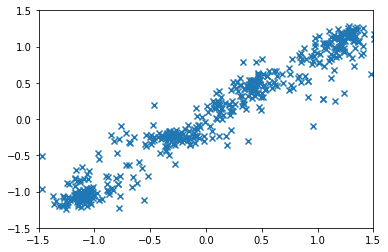

Epoch [39/100], Loss: 29.3297, Perplexity: 5466941986967.13
epoch 39 iteration 39000 loss 33.394 KL 6.998 weight 1.000 CE 527.308
epoch 39 iteration 39100 loss 26.704 KL 7.751 weight 1.000 CE 419.506
epoch 39 iteration 39200 loss 28.189 KL 7.308 weight 1.000 CE 443.718
epoch 39 iteration 39300 loss 25.393 KL 7.670 weight 1.000 CE 398.618
epoch 39 iteration 39400 loss 29.026 KL 8.509 weight 1.000 CE 455.904
epoch 39 iteration 39500 loss 26.879 KL 7.171 weight 1.000 CE 422.897
epoch 39 iteration 39600 loss 33.823 KL 7.839 weight 1.000 CE 533.325
epoch 39 iteration 39700 loss 28.236 KL 6.250 weight 1.000 CE 445.524
epoch 39 iteration 39800 loss 29.723 KL 8.391 weight 1.000 CE 467.173
epoch 39 iteration 39900 loss 29.170 KL 7.535 weight 1.000 CE 459.188


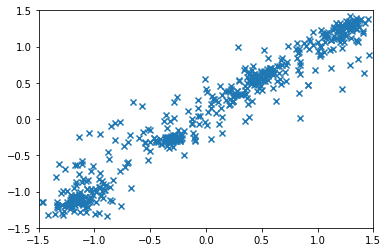

Epoch [40/100], Loss: 28.7044, Perplexity: 2925166172195.99
epoch 40 iteration 40000 loss 34.136 KL 7.636 weight 1.000 CE 538.543
epoch 40 iteration 40100 loss 26.832 KL 8.086 weight 1.000 CE 421.229
epoch 40 iteration 40200 loss 28.625 KL 7.595 weight 1.000 CE 450.402
epoch 40 iteration 40300 loss 25.378 KL 8.050 weight 1.000 CE 397.999
epoch 40 iteration 40400 loss 28.800 KL 7.810 weight 1.000 CE 452.991
epoch 40 iteration 40500 loss 26.814 KL 7.718 weight 1.000 CE 421.308
epoch 40 iteration 40600 loss 34.507 KL 7.651 weight 1.000 CE 544.460
epoch 40 iteration 40700 loss 28.126 KL 5.471 weight 1.000 CE 444.541
epoch 40 iteration 40800 loss 29.631 KL 8.778 weight 1.000 CE 465.315
epoch 40 iteration 40900 loss 29.306 KL 7.752 weight 1.000 CE 461.147


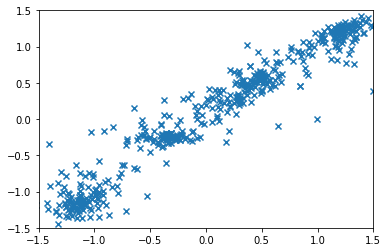

Epoch [41/100], Loss: 29.0817, Perplexity: 4266145303658.62
epoch 41 iteration 41000 loss 33.712 KL 7.807 weight 1.000 CE 531.577
epoch 41 iteration 41100 loss 27.048 KL 7.475 weight 1.000 CE 425.295
epoch 41 iteration 41200 loss 28.372 KL 7.362 weight 1.000 CE 446.585
epoch 41 iteration 41300 loss 25.469 KL 7.615 weight 1.000 CE 399.886
epoch 41 iteration 41400 loss 28.205 KL 7.894 weight 1.000 CE 443.393
epoch 41 iteration 41500 loss 26.810 KL 7.092 weight 1.000 CE 421.867
epoch 41 iteration 41600 loss 33.854 KL 7.351 weight 1.000 CE 534.308
epoch 41 iteration 41700 loss 28.374 KL 6.371 weight 1.000 CE 447.610
epoch 41 iteration 41800 loss 29.915 KL 9.245 weight 1.000 CE 469.401
epoch 41 iteration 41900 loss 29.624 KL 7.399 weight 1.000 CE 466.579


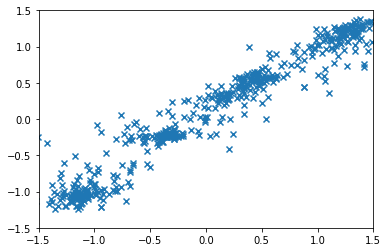

Epoch [42/100], Loss: 29.0907, Perplexity: 4304774734263.20
epoch 42 iteration 42000 loss 34.187 KL 6.977 weight 1.000 CE 540.021
epoch 42 iteration 42100 loss 26.947 KL 7.725 weight 1.000 CE 423.435
epoch 42 iteration 42200 loss 28.460 KL 7.141 weight 1.000 CE 448.227
epoch 42 iteration 42300 loss 25.427 KL 7.839 weight 1.000 CE 398.998
epoch 42 iteration 42400 loss 28.044 KL 8.142 weight 1.000 CE 440.570
epoch 42 iteration 42500 loss 26.775 KL 7.978 weight 1.000 CE 420.421
epoch 42 iteration 42600 loss 33.890 KL 7.773 weight 1.000 CE 534.471
epoch 42 iteration 42700 loss 28.241 KL 6.758 weight 1.000 CE 445.101
epoch 42 iteration 42800 loss 29.435 KL 8.946 weight 1.000 CE 462.020
epoch 42 iteration 42900 loss 29.355 KL 7.178 weight 1.000 CE 462.501


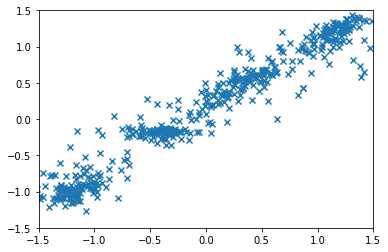

Epoch [43/100], Loss: 28.9661, Perplexity: 3800334592688.63
epoch 43 iteration 43000 loss 33.677 KL 7.462 weight 1.000 CE 531.368
epoch 43 iteration 43100 loss 27.419 KL 7.182 weight 1.000 CE 431.520
epoch 43 iteration 43200 loss 28.480 KL 7.996 weight 1.000 CE 447.677
epoch 43 iteration 43300 loss 25.505 KL 6.998 weight 1.000 CE 401.085
epoch 43 iteration 43400 loss 28.598 KL 7.897 weight 1.000 CE 449.666
epoch 43 iteration 43500 loss 26.554 KL 7.986 weight 1.000 CE 416.884
epoch 43 iteration 43600 loss 33.450 KL 7.852 weight 1.000 CE 527.341
epoch 43 iteration 43700 loss 28.328 KL 5.764 weight 1.000 CE 447.476
epoch 43 iteration 43800 loss 30.057 KL 8.724 weight 1.000 CE 472.185
epoch 43 iteration 43900 loss 29.135 KL 7.760 weight 1.000 CE 458.393


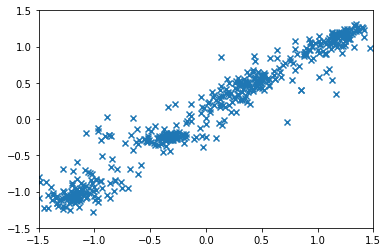

Epoch [44/100], Loss: 28.7857, Perplexity: 3172997805814.50
epoch 44 iteration 44000 loss 34.291 KL 7.163 weight 1.000 CE 541.491
epoch 44 iteration 44100 loss 27.253 KL 7.641 weight 1.000 CE 428.410
epoch 44 iteration 44200 loss 28.161 KL 7.560 weight 1.000 CE 443.018
epoch 44 iteration 44300 loss 25.084 KL 6.922 weight 1.000 CE 394.428
epoch 44 iteration 44400 loss 29.270 KL 8.128 weight 1.000 CE 460.190
epoch 44 iteration 44500 loss 26.588 KL 6.659 weight 1.000 CE 418.752
epoch 44 iteration 44600 loss 33.664 KL 7.775 weight 1.000 CE 530.852
epoch 44 iteration 44700 loss 28.099 KL 5.800 weight 1.000 CE 443.785
epoch 44 iteration 44800 loss 29.817 KL 9.667 weight 1.000 CE 467.407
epoch 44 iteration 44900 loss 29.243 KL 6.850 weight 1.000 CE 461.042


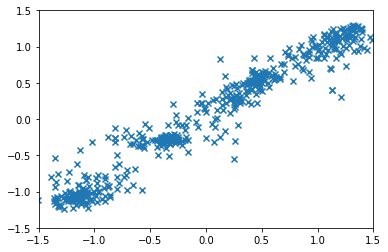

Epoch [45/100], Loss: 28.8043, Perplexity: 3232452203517.27
epoch 45 iteration 45000 loss 34.060 KL 7.122 weight 1.000 CE 537.843
epoch 45 iteration 45100 loss 26.935 KL 8.110 weight 1.000 CE 422.856
epoch 45 iteration 45200 loss 28.714 KL 6.985 weight 1.000 CE 452.436


KeyboardInterrupt: 

In [44]:
epochs = 100
annealing_args = {'type':'logistic', 'step':0, 'k':0.0025, 'first_step':2500}

iteration = 0
for epoch in range(epochs):
    for i in range(len(inputs)):
        x = inputs[i]
        y = torch.tensor(targets[i].reshape(-1), dtype=torch.long)
        
        mean, log_variance, outputs = vae(x)
        loss, cross_entropy, kl, kl_weight = loss_function(outputs, y, mean, log_variance, annealing=True, annealing_args=annealing_args)

        vae.zero_grad()
        loss.backward()
        clip_grad_norm_(vae.parameters(), 5.0)
        vae_optimizer.step()
        
        if iteration % 100 == 0:
            print('epoch {} iteration {} loss {:.3f} KL {:.3f} weight {:.3f} CE {:.3f}'.format(epoch, iteration, loss.data.item(), 
                                                                               kl.data.item(), kl_weight, cross_entropy.data.item()))

        iteration += 1
        annealing_args['step'] = iteration
        
    if epoch % 1 == 0:
        latent_grid = generate_grid(-20, 20, step, latent_size)
        true_posterior = compute_true_posterior(latent_grid, vae, tracked_inputs, tracked_targets)
        true_mean = compute_true_posterior_mean(true_posterior.t(), latent_grid)
        approximate_mean, _, outputs = vae(tracked_inputs)
        plt.scatter(true_mean.detach().numpy(), approximate_mean.detach().numpy(), marker='x')
        plt.xlim(-1.5, 1.5)
        plt.ylim(-1.5, 1.5)
        plt.show()
        print ('Epoch [{}/{}], Loss: {:.4f}, Perplexity: {:5.2f}'
               .format(epoch + 1, epochs, loss.item(), np.exp(loss.item())))